In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import skill_metrics as sm
import torch
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader
from copy import deepcopy
from src.dataset import GoncaDataset
from src.model import MLP, AutoEncoder, FinalModule, MLPLucas
import scipy.io as sio
import os

seaborn.set()
torch.manual_seed(32)
np.random.seed(32)

DATASET = 'GUNNING1'
HORIZONS = 12
WINDOW = 3
FORWARD_EXPANSION = 1
N_LAYERS = 1
DROPOUT = 0.0
DECOMP_METHOD = 'fft'
DEVICE = torch.device('cuda')

In [2]:
if not os.path.exists(f'data/components/{DATASET}'):
    os.system(f'mkdir data/components/{DATASET}')
if not os.path.exists(f'data/out/{DATASET}'):
    os.system(f'mkdir data/out/{DATASET}')

In [3]:
def plot_taylor(refs: dict, predictions_dict: dict):

    models = list(predictions_dict.keys())
    colors = ['c', 'm', 'y', 'k', 'r', 'b', 'g']
    colors = colors[:len(models)]
    models = {model: color for model, color in zip(models, colors)}
    for idx, (model, pred_dict) in enumerate(predictions_dict.items()):
        taylor_stats = []
        name = model[0]
        if model.endswith('ND'):
            name = name + 'ND'
        for horizon, pred in pred_dict.items():
            taylor_stats.append(sm.taylor_statistics(pred, refs[name][int(horizon)], 'data'))

        sdev = np.array([taylor_stats[0]['sdev'][0]]+[x['sdev'][1]
                                                    for x in taylor_stats])
        crmsd = np.array([taylor_stats[0]['crmsd'][0]]+[x['crmsd'][1]
                                                        for x in taylor_stats])
        ccoef = np.array([taylor_stats[0]['ccoef'][0]]+[x['ccoef'][1]
                                                        for x in taylor_stats])

        # To change other params in the plot, check SkillMetrics documentation in
        # https://github.com/PeterRochford/SkillMetrics/wiki/Target-Diagram-Options
        if len(list(predictions_dict.keys())) != 1:
            if idx != len(list(predictions_dict.keys()))-1 or len(list(predictions_dict.keys())) == 1:
                sm.taylor_diagram(sdev, crmsd, ccoef, styleOBS='-',
                                colOBS='g', markerobs='o',
                                titleOBS='Observation',
                                markercolor=models[model])
            else:
                sm.taylor_diagram(sdev, crmsd, ccoef, styleOBS='-',
                                titleOBS='Observation',
                                colOBS='g', markerobs='o', markercolor=models[model],
                                overlay = 'on', markerLabel=models)
        else:
            sm.taylor_diagram(sdev, crmsd, ccoef, styleOBS='-',
                      colOBS='g', markerobs='o',
                      titleOBS='Observation', markercolor='c',
                      markerLabel=['placeholder']+[
                          k+1 for k, v in pred_dict.items()])

In [4]:
dataset = GoncaDataset(window=WINDOW,
                           horizons=HORIZONS,
                           data_name=DATASET,
                           decomp_method=DECOMP_METHOD,
                           decomp=True)

train_loader = DataLoader(dataset, batch_size=128,
                            shuffle=True, num_workers=8)

input_example = next(iter(train_loader))[0]
input_size = input_example.shape[1]*input_example.shape[2]

/home/mateus/miniconda3/envs/ts/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
Decomp serie in 7 components
Getting test components


In [5]:
auto_encoder = AutoEncoder(input_size=input_size,
                               horizons=HORIZONS, device=DEVICE,
                               forward_expansion=FORWARD_EXPANSION,
                               num_layers=N_LAYERS,
                               dropout=DROPOUT)

trainer = Trainer(gpus=1, max_epochs=5)
trainer.fit(auto_encoder, train_dataloader=train_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mateus/miniconda3/envs/ts/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 813 K 
1 | decoder | Decoder | 1.1 M 
------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
Epoch 4: 100%|██████████| 67/67 [00:01<00:00, 43.76it/s, loss=0.000571, v_num=788, train_loss_step=0.000529, train_loss_epoch=0.000728]


1

In [6]:
final_model = FinalModule(input_size=input_size,
                              horizons=HORIZONS, device=DEVICE,
                              forward_expansion=FORWARD_EXPANSION,
                              num_layers=N_LAYERS,
                              dropout=DROPOUT)
final_model.load_encoder(auto_encoder.encoder)
trainer = Trainer(gpus=1, max_epochs=5)
trainer.fit(final_model, train_dataloader=train_loader)


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 813 K 
1 | fc_out  | Linear  | 6.2 K 
------------------------------------
6.2 K     Trainable params
813 K     Non-trainable params
819 K     Total params
Epoch 4: 100%|██████████| 67/67 [00:00<00:00, 72.48it/s, loss=0.00201, v_num=789, train_loss_step=0.00208, train_loss_epoch=0.00222]


1

In [7]:
dataset_lucas = GoncaDataset(window=WINDOW,
                                 horizons=HORIZONS,
                                 data_name=DATASET,
                                 decomp_method='2fft',
                                 decomp=True)

train_loader_lucas = DataLoader(dataset_lucas, batch_size=128,
                                shuffle=True, num_workers=8)
input_example_lucas = next(iter(train_loader_lucas))[0]
input_size_lucas = input_example_lucas.shape[1] * \
    input_example_lucas.shape[2]

mlp = MLPLucas(window_size=input_example_lucas.shape[1],
                n_comps=input_example_lucas.shape[2],
                horizons=HORIZONS)
trainer = Trainer(gpus=1, max_epochs=5)
trainer.fit(mlp, train_dataloader=train_loader_lucas)

Decomp serie in 7 components
/home/mateus/miniconda3/envs/ts/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
Decomp sub comp in 7 components
Decomp sub comp in 7 components
Decomp sub comp in 7 components
Decomp sub comp in 7 components
Decomp sub comp in 7 components
Decomp sub comp in 7 components
Decomp sub comp in 7 components
Getting test components
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mateus/miniconda3/envs/ts/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name        | Type       | Params
-------------------------------------------
0 | comp_layers | ModuleList | 28    
1 | fc_out      | Sequential | 81.7 K
-

1

In [27]:
from torch.nn.functional import mse_loss as MSE
from pytorch_forecasting.metrics import MAE, RMSE

dataset.set_type('test')
dataset_lucas.set_type('test')
mlp = mlp.cpu()
final_model = final_model.cpu()
X_test = dataset.samples
X_test_lucas = dataset_lucas.samples
y = dataset.labels
y_final = final_model(X_test).detach()/dataset.test_scaler.scale_
y_mlp = mlp(X_test_lucas).detach()/dataset_lucas.test_scaler.scale_
MLP = {key: list() for key in ['mse', 'rmse', 'mae']}
TAETS = {key: list() for key in ['mse', 'rmse', 'mae']}

for i in range(HORIZONS):
    mse = MSE(y_final[:, i], y[:, i]/dataset.test_scaler.scale_).item() 
    TAETS['mse'].append(mse)
    rmse = RMSE().loss(y_final[:, i], y[:, i]/dataset.test_scaler.scale_).mean().item()
    TAETS['rmse'].append(rmse)
    mae = MAE().loss(y_final[:, i], y[:, i]/dataset.test_scaler.scale_).mean().item()
    TAETS['mae'].append(mae)

for i in range(HORIZONS):
    mse = MSE(y_mlp[:, i], y[:, i]/dataset.test_scaler.scale_).item() 
    MLP['mse'].append(mse)
    rmse = RMSE().loss(y_mlp[:, i], y[:, i]/dataset.test_scaler.scale_).mean().item()
    MLP['rmse'].append(rmse)
    mae = MAE().loss(y_mlp[:, i], y[:, i]/dataset.test_scaler.scale_).mean().item()
    MLP['mae'].append(mae)

y_final = y_final.numpy()
y_mlp = y_mlp.numpy()
y = y.numpy()/dataset.test_scaler.scale_
preds = {}
preds['Transformer'] = {i: y_final[:, i] for i in range(HORIZONS)}
preds['MLP'] = {i: y_mlp[:, i] for i in range(HORIZONS)}
refs = {key: {i: y[:, i] for i in range(HORIZONS)} for key in ['T', 'M']}

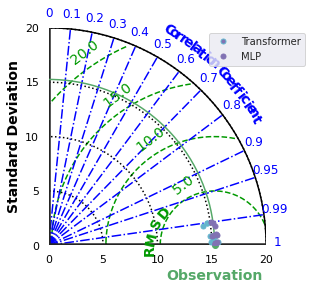

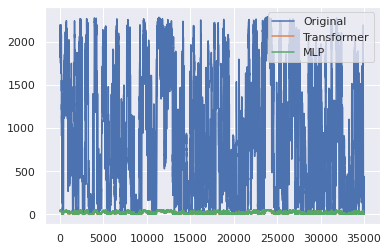

In [10]:
plot_taylor(refs, preds)
plt.show()

plt.plot(y[:, 0])
plt.plot(y_final[:, 0])
plt.plot(y_mlp[:, 0])
plt.legend(['Original', 'Transformer', 'MLP'])
plt.show()

# No decomposition

In [11]:
dataset_pure = GoncaDataset(window=WINDOW,
                           horizons=HORIZONS,
                           data_name=DATASET,
                           decomp_method='nodecomp',
                           decomp=True)

train_loader_pure = DataLoader(dataset_pure, batch_size=128,
                            shuffle=True, num_workers=8)

input_example = next(iter(train_loader_pure))[0]
input_size = input_example.shape[1]*input_example.shape[2]

auto_encoder_pure = AutoEncoder(input_size=input_size,
                               horizons=HORIZONS, device=DEVICE,
                               forward_expansion=FORWARD_EXPANSION,
                               num_layers=N_LAYERS,
                               dropout=DROPOUT)
trainer = Trainer(gpus=1, max_epochs=5)
trainer.fit(auto_encoder_pure, train_dataloader=train_loader_pure)

final_model_pure = FinalModule(input_size=input_size,
                              horizons=HORIZONS, device=DEVICE,
                              forward_expansion=FORWARD_EXPANSION,
                              num_layers=N_LAYERS,
                              dropout=DROPOUT)
final_model_pure.load_encoder(auto_encoder_pure.encoder)
trainer = Trainer(gpus=1, max_epochs=5)
trainer.fit(final_model_pure, train_dataloader=train_loader_pure)

mlp_pure = MLP(input_size=input_size, horizons=HORIZONS)
trainer = Trainer(gpus=1, max_epochs=5)
trainer.fit(mlp_pure, train_dataloader=train_loader_pure)


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mateus/miniconda3/envs/ts/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 804 K 
1 | decoder | Decoder | 1.1 M 
------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
Epoch 4: 100%|██████████| 548/548 [00:13<00:00, 39.63it/s, loss=0.00101, v_num=460, train_loss_step=0.00121, train_loss_epoch=0.00117]
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 804 K 
1 | fc_out  | Linear  | 6.2 K 
---------------------

1

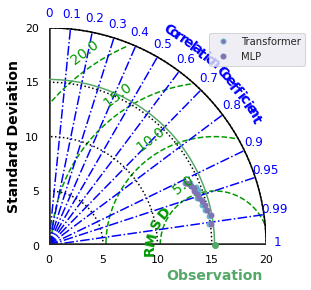

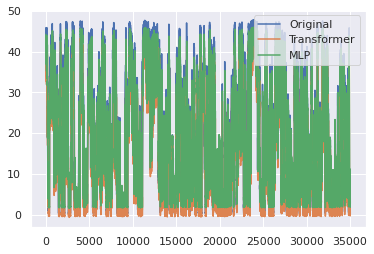

In [28]:
dataset_pure.set_type('test')
mlp_pure = mlp_pure.cpu()
final_model_pure = final_model_pure.cpu()
X_test_pure = dataset_pure.samples
y_pure = dataset_pure.labels/dataset_pure.test_scaler.scale_
y_final_pure = final_model_pure(X_test_pure).detach()/dataset_pure.test_scaler.scale_
y_mlp_pure = mlp_pure(X_test_pure).detach()/dataset_pure.test_scaler.scale_

MLP_PURE = {key: list() for key in ['mse', 'rmse', 'mae']}
TAETS_PURE = {key: list() for key in ['mse', 'rmse', 'mae']}

for i in range(HORIZONS):
    mse = MSE(y_final_pure[:, i], y_pure[:, i]).item() 
    TAETS_PURE['mse'].append(mse)
    rmse = RMSE().loss(y_final_pure[:, i], y_pure[:, i]).mean().item()
    TAETS_PURE['rmse'].append(rmse)
    mae = MAE().loss(y_final_pure[:, i], y_pure[:, i]).mean().item()
    TAETS_PURE['mae'].append(mae)

for i in range(HORIZONS):
    mse = MSE(y_mlp_pure[:, i], y_pure[:, i]).item() 
    MLP_PURE['mse'].append(mse)
    rmse = RMSE().loss(y_mlp_pure[:, i], y_pure[:, i]).mean().item()
    MLP_PURE['rmse'].append(rmse)
    mae = MAE().loss(y_mlp_pure[:, i], y_pure[:, i]).mean().item()
    MLP_PURE['mae'].append(mae)

y_final_pure = y_final_pure.numpy()
y_mlp_pure = y_mlp_pure.numpy()
y_pure = y_pure.numpy()
preds_pure = {}
preds_pure['Transformer'] = {i: y_final_pure[:, i] for i in range(HORIZONS)}
preds_pure['MLP'] = {i: y_mlp_pure[:, i] for i in range(HORIZONS)}
refs_pure = {key: {i: y_pure[:, i] for i in range(HORIZONS)} for key in ['T', 'M']}

plot_taylor(refs_pure, preds_pure)
plt.show()

plt.plot(y_pure[:, 11])
plt.plot(y_final_pure[:, 11])
plt.plot(y_mlp_pure[:, 11])
plt.legend(['Original', 'Transformer', 'MLP'])
plt.show()

In [13]:
preds = {'Nosso': y_final_pure, 'MLP': y_mlp_pure}
for method, prediction in preds.items():
    sio.savemat(f'data/out/{DATASET}/{DATASET}_{method}_pure.mat', {DATASET: prediction})

preds = {'Nosso': y_final, 'MLP': y_mlp}
for method, prediction in preds.items():
    sio.savemat(f'data/out/{DATASET}/{DATASET}_{method}_decomp.mat', {DATASET: prediction})

sio.savemat(f'data/out/{DATASET}/{DATASET}_ref.mat', {DATASET: y_pure})

In [36]:
for METRIC in ['mae', 'mse', 'rmse']:
    a = f"\multicolumn{'{1}'}{'{|c|}'}{'{'}{'t'}extbf{'{'}{DATASET}{'}'}{'}'} & \multicolumn{'{1}'}{'{|c|}'}{'{'}{round(MLP_PURE[METRIC][0], 2)}{'}'} & \multicolumn{'{1}'}{'{|c|}'}{'{'}{round(TAETS_PURE[METRIC][0], 2)}{'}'} & \multicolumn{'{1}'}{'{|c|}'}{'{'}{round(MLP[METRIC][0], 2)}{'}'} & \multicolumn{'{1}'}{'{|c|}'}{'{'}{round(TAETS[METRIC][0], 2)}{'}'} & \multicolumn{'{1}'}{'{|c|}'}{'{'}{round(MLP_PURE[METRIC][5], 2)}{'}'} & \multicolumn{'{1}'}{'{|c|}'}{'{'}{round(TAETS_PURE[METRIC][5], 2)}{'}'} & \multicolumn{'{1}'}{'{|c|}'}{'{'}{round(MLP[METRIC][5], 2)}{'}'} & \multicolumn{'{1}'}{'{|c|}'}{'{'}{round(TAETS[METRIC][5], 2)}{'}'} & \multicolumn{'{1}'}{'{|c|}'}{'{'}{round(MLP_PURE[METRIC][11], 2)}{'}'} & \multicolumn{'{1}'}{'{|c|}'}{'{'}{round(TAETS_PURE[METRIC][11], 2)}{'}'} & \multicolumn{'{1}'}{'{|c|}'}{'{'}{round(MLP[METRIC][11], 2)}{'}'} & \multicolumn{'{1}'}{'{|c|}'}{'{'}{round(TAETS[METRIC][11], 2)}{'}'} \\\ \hline"
    print(METRIC)
    print(a)
    print('-------------')
    print()
    print()

mae
\multicolumn{1}{|c|}{textbf{GUNNING1}} & \multicolumn{1}{|c|}{1.25} & \multicolumn{1}{|c|}{3.81} & \multicolumn{1}{|c|}{0.11} & \multicolumn{1}{|c|}{0.4} & \multicolumn{1}{|c|}{3.06} & \multicolumn{1}{|c|}{3.49} & \multicolumn{1}{|c|}{0.59} & \multicolumn{1}{|c|}{0.72} & \multicolumn{1}{|c|}{4.37} & \multicolumn{1}{|c|}{4.7} & \multicolumn{1}{|c|}{1.36} & \multicolumn{1}{|c|}{1.51} \\ \hline
-------------


mse
\multicolumn{1}{|c|}{textbf{GUNNING1}} & \multicolumn{1}{|c|}{3.89} & \multicolumn{1}{|c|}{17.52} & \multicolumn{1}{|c|}{0.04} & \multicolumn{1}{|c|}{0.23} & \multicolumn{1}{|c|}{21.5} & \multicolumn{1}{|c|}{25.67} & \multicolumn{1}{|c|}{0.91} & \multicolumn{1}{|c|}{1.06} & \multicolumn{1}{|c|}{39.95} & \multicolumn{1}{|c|}{46.2} & \multicolumn{1}{|c|}{4.67} & \multicolumn{1}{|c|}{5.2} \\ \hline
-------------


rmse
\multicolumn{1}{|c|}{textbf{GUNNING1}} & \multicolumn{1}{|c|}{3.89} & \multicolumn{1}{|c|}{17.52} & \multicolumn{1}{|c|}{0.04} & \multicolumn{1}{|c|}{0.23} & \mu